In [8]:
from app.utils.logging_config import setup_logging
from sqlalchemy import select
from app.database import get_db, init_db
from app.models.camera import Camera
from app.utils.model_loader import load_models
from app.core.camera_manager import CameraManager, get_camera_manager

async def start():
    await init_db()
    await load_models()
    camera_manager = await get_camera_manager()
    await camera_manager.initialize()
    logger = setup_logging()

    async for session in get_db():
        # Get all enabled cameras
        query = select(Camera).where(Camera.enabled == True)
        result = await session.execute(query)
        enabled_cameras = result.scalars().all()
        
        logger.info(f"Found {len(enabled_cameras)} enabled cameras")
        
        # Initialize processing for each camera
        for camera in enabled_cameras:
            # Check if camera should be processed for AI
            needs_ai_processing = (
                camera.detect_people or 
                camera.count_people or 
                camera.recognize_faces or 
                camera.template_matching
            )
            
            if needs_ai_processing:
                # Add camera to manager and start AI processing
                logger.info(f"Starting processing for camera {camera.id}: {camera.name}")
                await camera_manager.add_camera(camera, start_processing=True)
            else:
                # Add camera to manager for streaming only
                logger.info(f"Adding camera {camera.id}: {camera.name} for streaming only")
                await camera_manager.add_camera(camera, start_processing=False)

        jpg = await camera_manager.get_jpeg_frame(1)
        return jpg
a = await start()

INFO: Loading AI models...
INFO: AI models loaded successfully
INFO: Found 1 enabled cameras
INFO: Adding camera 1: CID Moosa for streaming only
C:\Users\iamro\AppData\Local\Temp\ipykernel_32852\1430967504.py:44: RuntimeWarning: coroutine 'CameraManager.get_jpeg_frame' was never awaited
  a = await start()


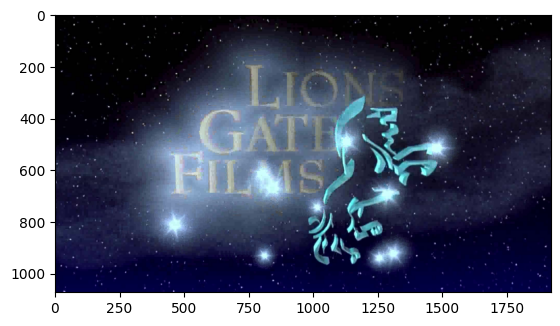

In [14]:
import cv2
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import io

def bytes_to_image(image_bytes):
    # Convert bytes to numpy array
    nparr = np.frombuffer(image_bytes, np.uint8)
    # Decode image
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Convert to PIL Image
    pil_img = Image.fromarray(img_rgb)
    # Display the image
    imshow(pil_img)

bytes_to_image(a)
